# Predicting non-functional water pumps in Tanzania

I decided take participation on current competition beckause I really care about future of the planet and water problem is global problem

"There is a water crisis today. But the crisis is not about having too little water to satisfy our needs. It is a crisis of managing water so badly that billions of people - and the environment - suffer badly."    World Water Vision Report

By 2020 about 30-40% of the world will have water scarcity, and according to the researchers, climate change can make this even worse.

By 2025, an estimated 1.8 billion people will live in areas plagued by water scarcity, with two-thirds of the world’s population living in water-stressed regions.


https://www.seametrics.com/blog/future-water/

About competition

https://www.drivendata.org/competitions/7/

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

# feature description

amount_tsh - Total static head (amount water available to waterpoint)

date_recorded - The date the row was entered

funder - Who funded the well

gps_height - Altitude of the well

installer - Organization that installed the well

longitude - GPS coordinate

latitude - GPS coordinate

wpt_name - Name of the waterpoint if there is one

num_private - No information about this column

basin - Geographic water basin

subvillage - Geographic location

region - Geographic location

region_code - Geographic location (coded)

district_code - Geographic location (coded)

lga - Geographic location

ward - Geographic location

population - Population around the well

public_meeting - True/False

recorded_by - Group entering this row of data

scheme_management - Who operates the waterpoint

scheme_name - Who operates the waterpoint

permit - If the waterpoint is permitted

construction_year - Year the waterpoint was constructed

extraction_type - The kind of extraction the waterpoint uses

extraction_type_group - The kind of extraction the waterpoint uses

extraction_type_class - The kind of extraction the waterpoint uses

management - How the waterpoint is managed

management_group - How the waterpoint is managed

payment - What the water costs

payment_type - What the water costs

water_quality - The quality of the water

quality_group - The quality of the water

quantity - The quantity of water

quantity_group - The quantity of water

source - The source of the water

source_type - The source of the water

source_class - The source of the water

waterpoint_type - The kind of waterpoint

waterpoint_type_group - The kind of waterpoint

# import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pygal
from IPython.display import display, HTML
from pygal.style import Style

# for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


# load data

In [2]:
train = pd.read_csv('train.csv')
target = pd.read_csv('target.csv')
test = pd.read_csv('test.csv')

# say hello to data

In [119]:
# data info and distribution
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [120]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [2]:
# plot map

In [3]:
base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

def galplot(chart):
    rendered_chart = chart.render(is_unicode=True)
    plot_html = base_html.format(rendered_chart=rendered_chart)
    display(HTML(plot_html))


bar_chart = pygal.Bar(height=400)
bar_chart.title = 'target distribution'

total = target.shape[0]
status_group_shares = target.status_group.value_counts()/total

for st_group_name, st_group_name_shape in status_group_shares.items():
    bar_chart.add(st_group_name, st_group_name_shape)
bar_chart.render()
galplot(bar_chart)

# plot missing values

In [3]:
train[['amount_tsh', 'num_private', 'population' ,'construction_year']] = \
    train[['amount_tsh', 'num_private', 'population' ,'construction_year']].replace(0, np.NaN)

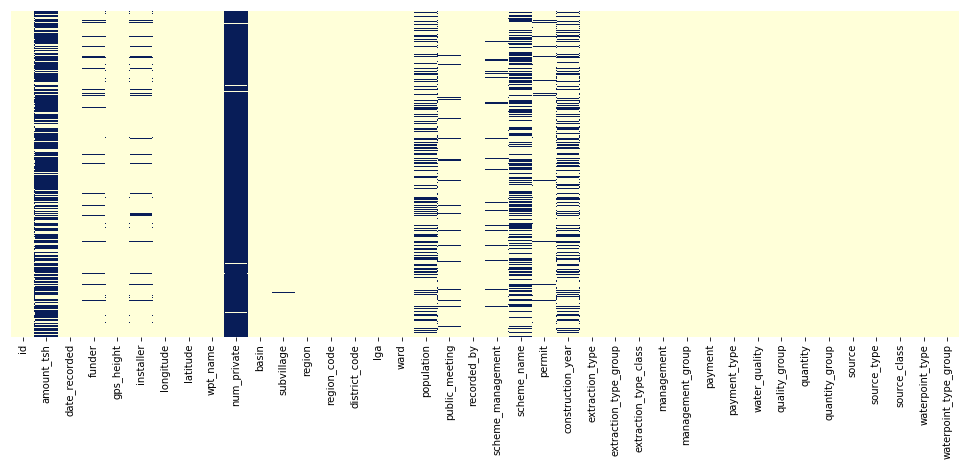

In [140]:
plt.figure(figsize=(17,6));
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, cmap="YlGnBu")
plt.show()

# drop usless columns
scheme_name has a lot of missing data and it dont look like very informative

and num_private in mostly 0 (nan) and we dont know info about this colums

In [4]:
train.drop(['wpt_name', 'recorded_by', 'longitude', 'latitude','scheme_name', 'num_private'], 1, inplace=True)

region_code and district_code are integers, but categorical

devide data by info type

In [5]:
train[['region_code', 'district_code']]= train[['region_code', 'district_code']].astype('object')
train[['date_recorded', 'construction_year']]= train[['date_recorded', 'construction_year']].apply((pd.to_datetime))

categoricals = train.select_dtypes(include = ['object']).columns.tolist()
numerical = train.select_dtypes(include = ['int', 'float']).columns.tolist()
date_cols = train.select_dtypes(include = ['datetime64']).columns.tolist()

merge target and features

In [6]:
df = pd.merge(train, target, how = 'inner', on = 'id')

# work with numerical features

In [7]:
numerical

['id', 'amount_tsh', 'gps_height', 'population']

now 'id' no need to be keept

In [8]:
df.drop('id', 1, inplace=True)

population - Population around the well

check population distrib for geo features

In [154]:
for name, values in df[['region', 'population']].groupby('region').population.apply(list).items():
    print(i)

('Arusha', [200.0, 100.0, 150.0, 130.0, 140.0, 360.0, 120.0, 120.0, 370.0, 150.0, 120.0, 400.0, 200.0, 150.0, 90.0, 210.0, 150.0, 96.0, 150.0, 200.0, 360.0, 300.0, 200.0, 400.0, 100.0, 250.0, 100.0, 159.0, 1.0, 300.0, 210.0, 210.0, 200.0, 250.0, 200.0, 150.0, 200.0, 200.0, 200.0, 130.0, 150.0, 210.0, 123.0, 250.0, 150.0, 150.0, 1.0, 89.0, 500.0, 350.0, 980.0, 1500.0, 2000.0, 1.0, 200.0, 400.0, 150.0, 300.0, 130.0, 100.0, 145.0, 150.0, 130.0, 200.0, 400.0, 150.0, 100.0, 150.0, 150.0, 150.0, 200.0, 120.0, 130.0, 150.0, 200.0, 100.0, 1.0, 1.0, 200.0, 400.0, 620.0, 200.0, 150.0, 150.0, 200.0, 380.0, 68.0, 50.0, 350.0, 875.0, 368.0, 210.0, 200.0, 230.0, 120.0, 100.0, 120.0, nan, 150.0, 450.0, 200.0, 100.0, 200.0, 400.0, 670.0, 140.0, 96.0, 87.0, 120.0, 150.0, 150.0, 200.0, 100.0, 150.0, 180.0, 200.0, 200.0, 250.0, 200.0, 200.0, 120.0, 150.0, 1.0, 400.0, 200.0, 200.0, 180.0, 230.0, 150.0, 152.0, 150.0, 200.0, 139.0, 360.0, 198.0, 300.0, 1200.0, 200.0, 210.0, 120.0, 300.0, 150.0, 150.0, 150.0

In [204]:
for col in ['region_code', 'district_code']:
    box_plot = pygal.Box(box_mode="tukey", heigh = 400)
    box_plot.title = f'population distribution based on {col}'
    for name, values in df[[col, 'population']].groupby(col).population.apply(list).items():
        # some grouping could give list from nan's
        if (sum(values) > 0) and (len(values)>1):
            print(len(values))
            box_plot.add(name, values)
    #box_plot.render()
    galplot(box_plot)

3024
4379
2513
4040
1609
805
300
390
2640
5300
2093
1808
2816
5011
3324
3047
1969
1583
326
1025
1238
917
423


TypeError: object of type 'int' has no len()

In [172]:
for col in ['region' , 'region_code', 'district_code']:
    box_plot = pygal.Box(box_mode="tukey", heigh = 400)
    box_plot.title = f'population distribution based on {col}'
    for name, values in df[[col, 'population']].groupby(col).population.apply(list).items():
        box_plot.add(name, values)
    #box_plot.render()
    galplot(box_plot)

ValueError: cannot convert float NaN to integer

/Users/danil/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


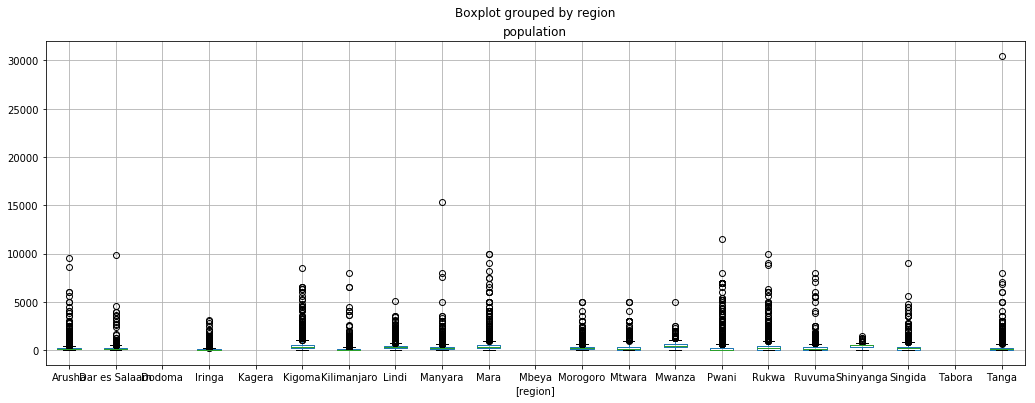

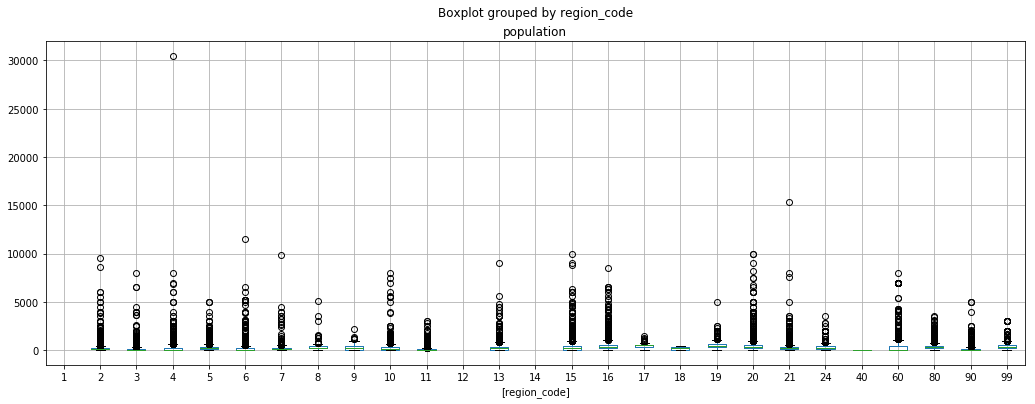

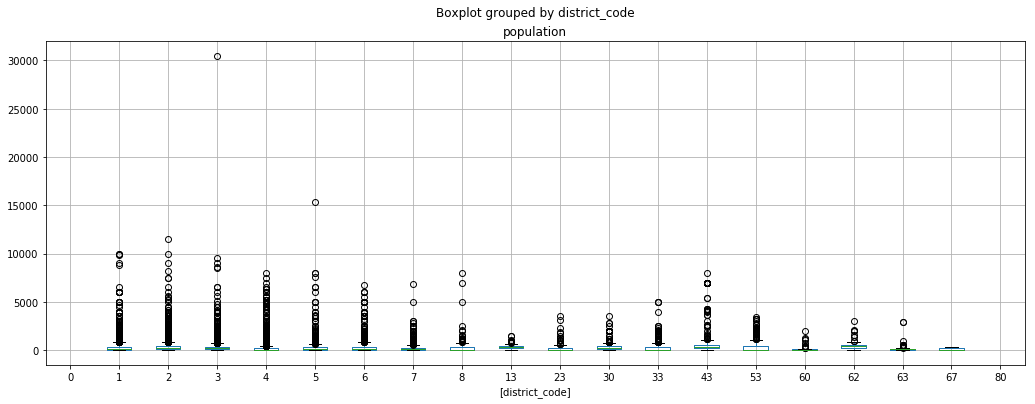

In [7]:
for col in ['region' , 'region_code', 'district_code']:
    df[[col, 'population']].boxplot(by=col, figsize=(17,6))
plt.show()

as I can see there a lot of outliers and try to fill missing population will be not precise, so I will just fill it with 0

In [9]:
df['missed_population'] = np.where(np.isnan(df['population']), 1, 0)
df['population'].fillna(0, inplace = True)

amount_tsh - Total static head (amount water available to waterpoint)

In [177]:
df.isnull().amount_tsh.sum()

41639

/Users/danil/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


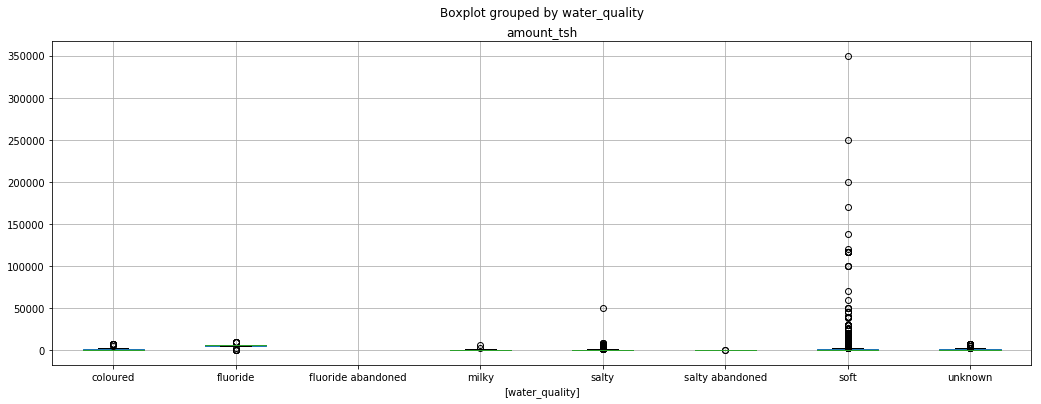

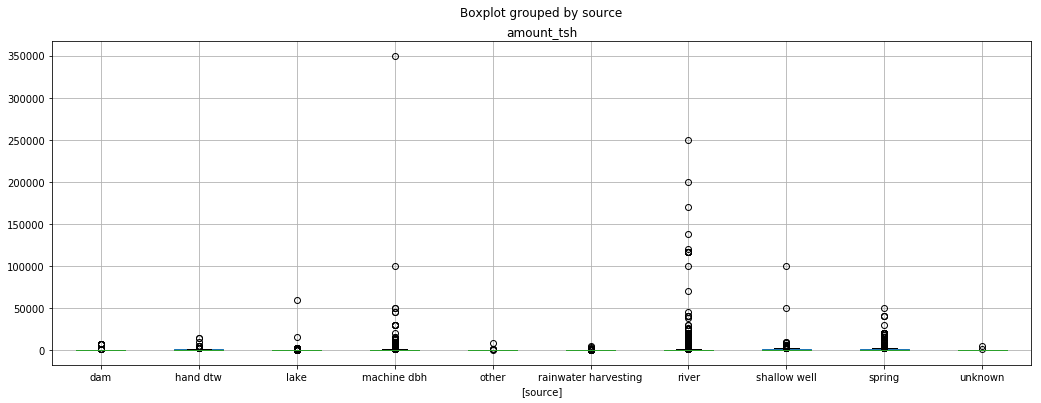

In [10]:
# amount_tsh - Total static head (amount water available to waterpoint)
# check amount_tsh distrib for water features
for col in ['water_quality' , 'source']:
    df[[col, 'amount_tsh']].boxplot(by=col, figsize=(17,6))
plt.show()

loocks like better to fill na with mode in water_quality groupe, except 

In [10]:
df['approximated_amount_tsh'] = np.where(np.isnan(df['amount_tsh']), 1, 0) 
replacements = df.groupby('water_quality').amount_tsh.agg(pd.Series.mode).to_dict()

# all vlaues amount_tsh in this category is Nan
replacements.pop('fluoride abandoned')

df.loc[df['water_quality'] != 'soft', 'amount_tsh'] = \
    df.loc[df['water_quality'] != 'soft', 'amount_tsh'].fillna(replacements)

df['amount_tsh'].fillna(0, inplace=True)

In [11]:
df['amount_tsh']

0         6000.0
1            0.0
2           25.0
3            0.0
4            0.0
5           20.0
6            0.0
7            0.0
8            0.0
9            0.0
10           0.0
11         200.0
12           0.0
13           0.0
14           0.0
15           0.0
16         500.0
17           0.0
18           0.0
19         500.0
20         200.0
21           0.0
22           0.0
23         500.0
24           0.0
25           0.0
26         500.0
27           0.0
28           0.0
29           0.0
          ...   
59370      200.0
59371        0.0
59372        0.0
59373     5000.0
59374        0.0
59375    40000.0
59376        0.0
59377        0.0
59378      500.0
59379        0.0
59380     6000.0
59381        0.0
59382        6.0
59383        0.0
59384        0.0
59385      500.0
59386        0.0
59387      100.0
59388        0.0
59389        0.0
59390        0.0
59391        0.0
59392        0.0
59393        0.0
59394      500.0
59395       10.0
59396     4700.0
59397        0

gps_height - Altitude of the well

info from Wiki 
The country is the site of Africa's highest and lowest points: Mount Kilimanjaro, at 5,895 metres (19,341 ft) above sea level, and the floor of Lake Tanganyika, at 352 metres (1,155 ft) below sea level, respectively. So it means there should not be negative values

In [15]:
df['wrong_gps_height'] = np.where(df['gps_height'] < 0, 1, 0) 

In [16]:
df['gps_height'].describe()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64

I think converting nevative values to positive would work pretty well

In [17]:
df['gps_height'] = abs(df['gps_height'])

# work with categorial features

count unique values of all column to estimate dataset shape after get_dummies

In [19]:
categories = 0
for col in categoricals:
    categories += len(train[col].unique())
    print(col, len(train[col].unique()))
print('-------------------- \ntotal num:', categories)

funder 1898
installer 2146
basin 9
subvillage 19288
region 21
region_code 27
district_code 20
lga 125
ward 2092
public_meeting 3
scheme_management 13
permit 3
extraction_type 18
extraction_type_group 13
extraction_type_class 7
management 12
management_group 5
payment 7
payment_type 7
water_quality 8
quality_group 6
quantity 5
quantity_group 5
source 10
source_type 7
source_class 3
waterpoint_type 7
waterpoint_type_group 6
-------------------- 
total num: 25771


looks very immense

In [20]:
df[categoricals] = df[categoricals].astype('str')
df[categoricals] = df[categoricals].applymap(lambda x: x.lower())
nan_list = ['not known','unknown','none','-','##','not kno','unknown installer', '0', 'dwe']
df = train.replace(nan_list, np.nan)

# Any feature values with fewer than 50 rows would be turned into a 'other'
for feature in df[categoricals]:
    # Determine which feature values to keep
    remove = df[feature].value_counts()[df[feature].value_counts() < 50].index.tolist()
    #print(remove)
    #to_keep = train[feature].value_counts()[train[feature].value_counts() > 50].index.tolist()
    
    # Turn those into NANs (using a copy, to prevent warnings)
    feature_copy = df[feature].copy()
    #feature_copy[~feature_copy.isin(to_keep)] = np.nan
    feature_copy[feature_copy.isin(remove)] = np.nan
    #print(feature_copy.isnull().sum())
    df[feature] = feature_copy
# Fix all NANs
df[categoricals] = df[categoricals].fillna('other')

In [186]:
df[['installer', 'funder']].head(20)

,installer,funder
0,Roman,Roman
1,other,Grumeti
2,World vision,other
3,UNICEF,Unicef
4,Artisan,other
5,DWE,Mkinga Distric Coun
6,DWSP,Dwsp
7,DWE,Rwssp
8,other,Wateraid
9,Artisan,other


as we can see that funder and installer often have the same value or a little bit different, and DWE appears so often

and I cant find any info about this installer on the internet, so it could be smth like 'no info'

In [ ]:
line_chart = pygal.Bar()
line_chart.title = 'Browser usage evolution (in %)'
line_chart.x_labels = map(str, range(2002, 2013))
line_chart.add('Firefox', [None, None, 0, 16.6,   25,   31, 36.4, 45.5, 46.3, 42.8, 37.1])
line_chart.add('Chrome',  [None, None, None, None, None, None,    0,  3.9, 10.8, 23.8, 35.3])
line_chart.add('IE',      [85.8, 84.6, 84.7, 74.5,   66, 58.6, 54.7, 44.8, 36.2, 26.6, 20.1])
line_chart.add('Others',  [14.2, 15.4, 15.3,  8.9,    9, 10.4,  8.9,  5.8,  6.7,  6.8,  7.5])
line_chart.render()

In [16]:
def plot_category_breakdown(df, cat_col):
    grouped = df.groupby([cat_col, 'status_group']).status_group.agg({'status_group_count':'count'})
    pivot_t = pd.pivot_table(grouped, index=cat_col, columns='status_group', values='status_group_count')
    pivot_t.sort_values('functional', ascending=False).plot.bar(figsize=(17,6), label=cat_col)
    #plt.label(cat)
    plt.show()

/Users/danil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


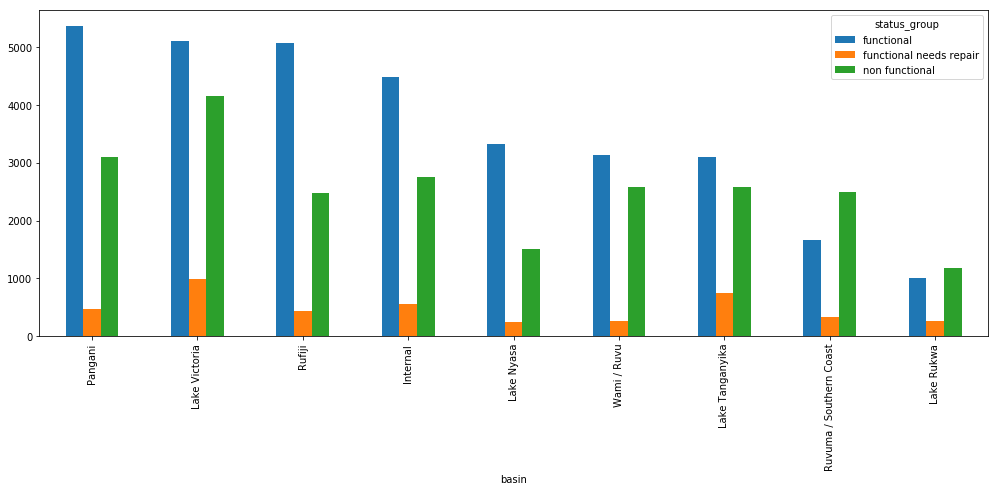

In [17]:
plot_category_breakdown(df, 'basin')

In [18]:
# in this cases I would not amend feature 

In [ ]:
# region and region_code look like almost the same but have different unique values

In [29]:
print(len(df.region.unique()))
print(len(df.region_code.unique()))
print(len(df.district_code.unique()))

AttributeError: 'DataFrame' object has no attribute 'region'

In [21]:
# I checked that Tanzania has 31 region, so I will drop column 'region', beckause there is less values
df.drop(['region', 'district_code'], 1, inplace=True)

# extraction_type has very close values with extraction_type_group and extraction_type_class but extraction_type
# has more values so I will 
# remove extraction_type_group, extraction_type_class

df.drop(['extraction_type_group', 'extraction_type_class'], 1, inplace=True)

/Users/danil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


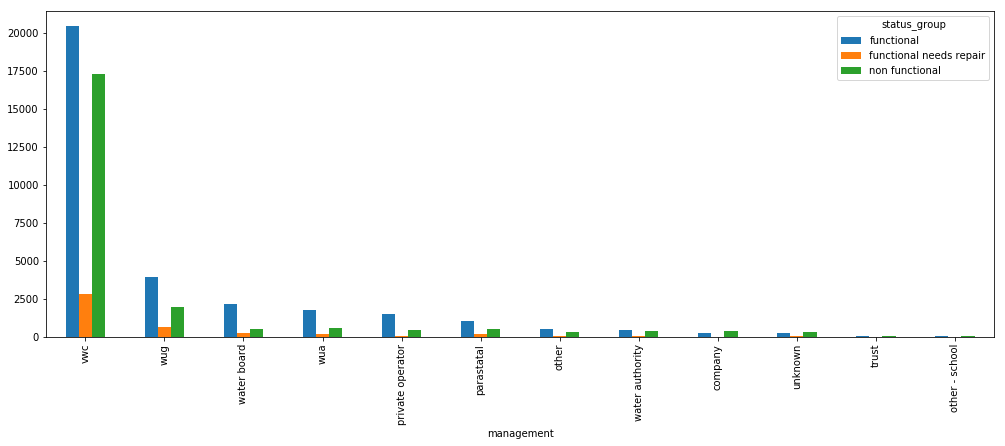

In [31]:
plot_category_breakdown(df, 'management')

/Users/danil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


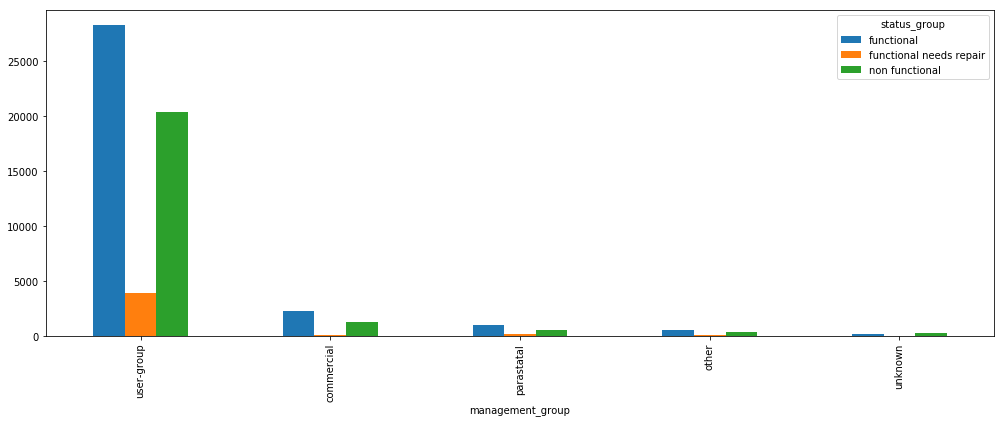

In [32]:
plot_category_breakdown(df, 'management_group')

In [17]:
# majority of 'management' looks the same so I will remove this columns and leave 'management_group' 
# and join small columns to 'other' 
df.management_group = df.management_group.apply(lambda x: 'other' if x != 'user-group' else x)

In [22]:
df[df.management_group == 'other'].groupby('status_group').status_group.count()/df[df.management_group == 'other'].shape[0]

status_group
functional                 0.579884
functional needs repair    0.059479
non functional             0.360637
Name: status_group, dtype: float64

In [23]:
df[df.management_group == 'user-group'].groupby('status_group').status_group.count()/df[df.management_group == 'user-group'].shape[0]

status_group
functional                 0.538236
functional needs repair    0.074414
non functional             0.387350
Name: status_group, dtype: float64

In [18]:
# need to check shares in groups but nice and remove it
# distribution in classes looks the same and this is not informative, will remove it
df.drop(['management', 'management_group'], 1, inplace=True)

/Users/danil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


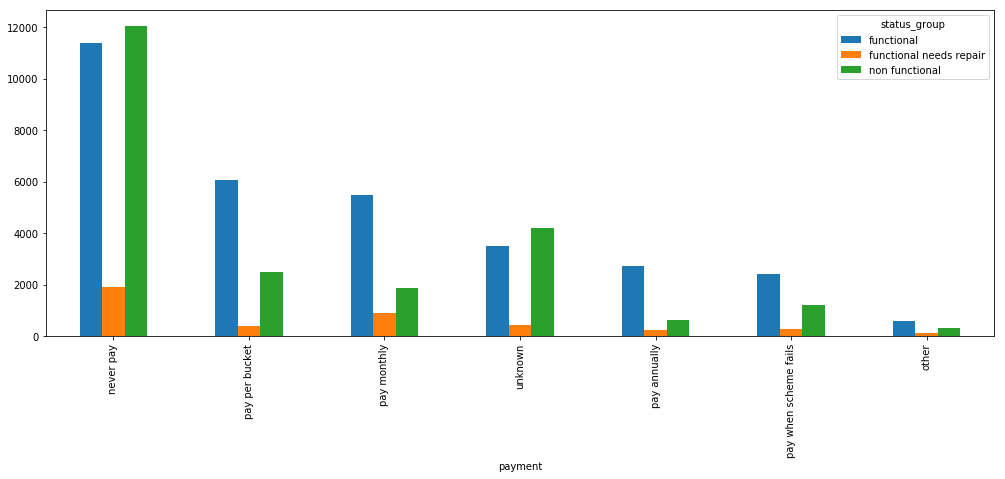

In [43]:
plot_category_breakdown(df,  'payment')

In [19]:
# join pay to 1 group and others to another
unpayable_types = ['never pay', 'other']
df.payment = df.payment.apply(lambda x: 0 if x in unpayable_types else 1)

In [20]:
df.drop('payment_type', 1, inplace=True)
# beckause payment shows the same info

# quality_group looks very close to water_quality, so I will remove one
df.drop(['water_quality'], 1, inplace=True)

# quantity_group and quantity have the same info, so I will remove second one and join 'other' with 'dry' 
# beckause it small group
df.drop(['quantity_group'], 1, inplace=True)

#df.quantity = 
df.quantity.replace({'dry': 'other'}, inplace=True)

# I will drop source_class and source_type becuase source is more detailed
df.drop(['source_class', 'source_type'], 1, inplace=True)

# waterpoint_type_group and waterpoint_type looks the same but  waterpoint_type more detailed
df.drop('waterpoint_type_group', 1, inplace=True)

# I will join 2 small classes with close distribution
df.waterpoint_type.replace({'cattle trough':'improved spring'}, inplace=True)

# work with date features

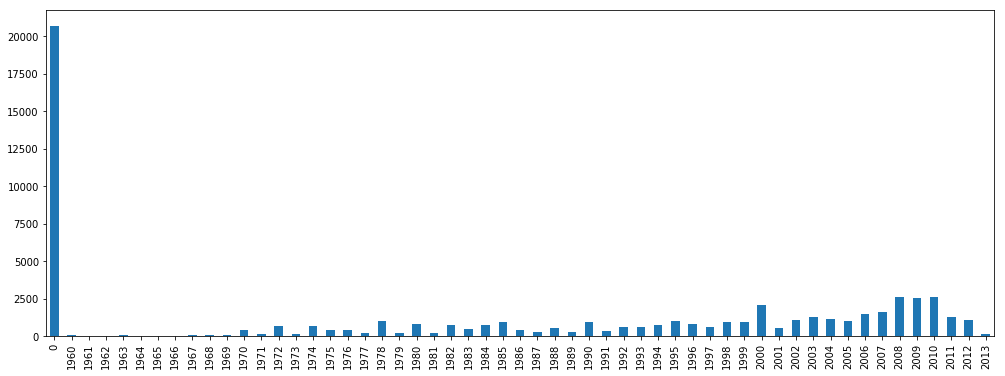

In [21]:
df.construction_year.fillna(0, inplace=True)
df.construction_year = df.construction_year.astype(int)

# I will use create column as lifetime value from date_recorded and construction_year
df.construction_year.value_counts().sort_index().plot.bar(figsize=(17,6))
plt.show()

In [42]:
df[df.construction_year == 0].shape[0]/df.shape[0]

0.34863636363636363

In [22]:
df.construction_year = df.construction_year.replace(0, np.NaN)

In [118]:
len(df.construction_year) - df.construction_year.count()

20709

In [23]:
# add column that means that construction_year was filled with approximation
df['approximated_construction_year'] = df['construction_year'].apply(lambda x: 1 if np.isnan(x) else 0)

In [24]:
replacements = df.groupby(['funder', 'installer'])['construction_year'].transform('mean').round(0)
df['construction_year'] = df['construction_year'].fillna(replacements)

replacements = df.groupby('installer')['construction_year'].transform('mean').round(0)
df['construction_year'] = df['construction_year'].fillna(replacements)

replacements = df.groupby('funder')['construction_year'].transform('mean').round(0)
df['construction_year'] = df['construction_year'].fillna(replacements)

df.construction_year.fillna(df.construction_year.mode()[0], inplace=True)

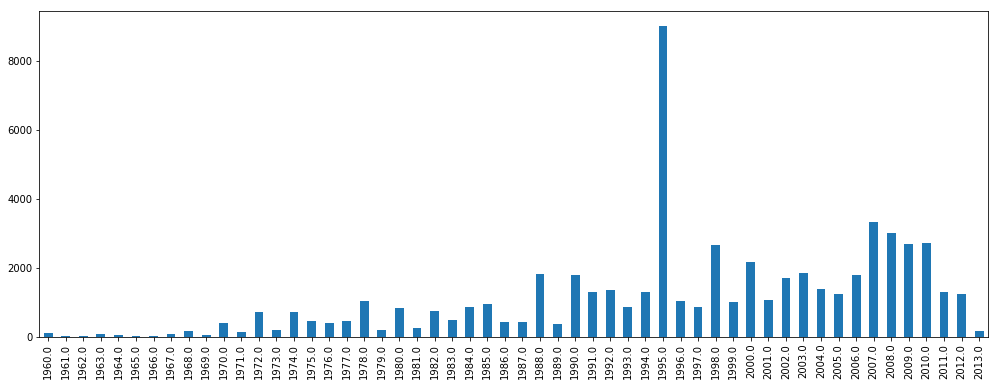

In [36]:
# I will use create column as lifetime value from date_recorded and construction_year
df.construction_year.value_counts().sort_index().plot.bar(figsize=(17,6))
plt.show()

In [ ]:
# add lifetime date recorded - construction_year

# save data

In [25]:
# before replacing subvillages I would like to add column that represent number of watermomps in subwillage
wp_in_subvillages = df['subvillage'].value_counts().to_dict()

df['wp_in_subvillage'] = df['subvillage'].replace(wp_in_subvillages)

In [26]:
# try to fill rows with empty subwillage with grouped Nan 
# but i think better to remove it
df['wp_in_subvillage'].fillna(df[df['wp_in_subvillage'].isnull()].shape[0], inplace=True)

In [27]:
df[df['wp_in_subvillage'].isnull()].shape[0]

0

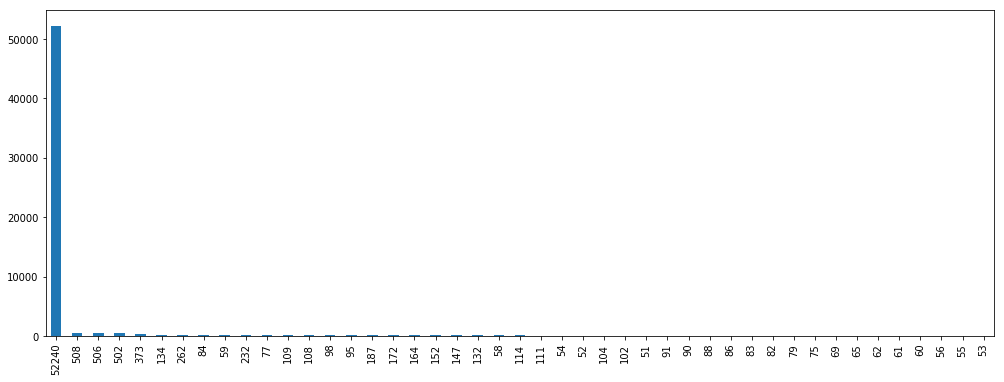

In [28]:
plt.figure(figsize=(17,6));
df['wp_in_subvillage'].value_counts().plot(kind="bar")
plt.show()

In [28]:
# the same for lga and ward
wp_in_lga = df['lga'].value_counts().to_dict()

df['wp_in_lga'] = df['lga'].replace(wp_in_lga)

In [29]:
wp_in_ward = df['ward'].value_counts().to_dict()

df['wp_in_ward'] = df['ward'].replace(wp_in_ward)

In [30]:
df.drop(['subvillage', 'lga', 'ward'],1, inplace=True)

In [31]:
df.to_csv('prepeared_features.csv')

# modelling

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [31]:
df['wp_in_subvillage'] = df['wp_in_subvillage'].astype(int)

In [12]:
numerical = df.select_dtypes(include = ['float64']).columns.tolist()

In [13]:
numerical

['amount_tsh', 'population']

In [23]:
df[numerical]

,amount_tsh,population
0,6000.0,109.0
1,NaN,280.0
2,25.0,250.0
3,NaN,58.0
4,NaN,NaN
5,20.0,1.0
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [36]:
scaler = RobustScaler()
nums_scaled = scaler.fit_transform(df[numerical])
nums_scaled = pd.DataFrame(nums_scaled, columns=numerical)
df[numerical] = nums_scaled

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [50]:
target = df.status_group.replace(['functional', 'non functional', 'functional needs repair'], [2, 0, 1])

In [57]:
target = df.status_group
df.drop('status_group', 1, inplace=True)

In [58]:
categorial = df.select_dtypes(include = ['object']).columns.tolist()

In [59]:
categorial

['funder',
 'installer',
 'basin',
 'region_code',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type']

In [53]:
train_dum = pd.get_dummies(df, dummy_na=False, prefix = categorial)
train_dum.shape

(59400, 4153)

In [62]:
numerical = df.select_dtypes(include = ['float', 'int']).columns.tolist()

In [63]:
numerical

['amount_tsh',
 'gps_height',
 'population',
 'construction_year',
 'payment',
 'missed_population',
 'approximated_amount_tsh',
 'wrong_gps_height',
 'approximated_construction_year',
 'wp_in_subvillage',
 'wp_in_lga',
 'wp_in_ward']

In [82]:
df[numerical].describe()

,amount_tsh,gps_height,population,construction_year,payment,missed_population,approximated_amount_tsh,wrong_gps_height,approximated_construction_year,wp_in_subvillage,wp_in_lga,wp_in_ward
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,15.882519,669.304310,0.720512,-0.024387,0.555522,0.359949,0.700993,0.025185,0.348636,34.059293,715.051953,56.453771
std,149.878728,692.143911,2.192940,0.719703,0.496912,0.479989,0.457827,0.156689,0.476543,93.009112,477.234447,48.427728
min,0.000000,0.000000,-0.116279,-2.466667,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,-0.116279,-0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,399.000000,25.000000
50%,0.000000,369.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,5.000000,626.000000,43.000000
75%,1.000000,1319.250000,0.883721,0.600000,1.000000,1.000000,1.000000,0.000000,1.000000,13.000000,877.000000,70.000000
max,17500.000000,2770.000000,141.744186,1.066667,1.000000,1.000000,1.000000,1.000000,1.000000,508.000000,2503.000000,307.000000


In [75]:
df_preproc = pd.concat([train_dum, df[numerical]], 1)

In [73]:
pd.DataFrame(target)

,status_group
0,2
1,2
2,2
3,0
4,2
5,2
6,0
7,0
8,0
9,2


In [91]:
df_preproc_t = df_preproc.drop(['date_recorded'], 1)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(df_preproc_t, target, test_size=0.33, random_state=42)

In [95]:
models = []

models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

#testing models

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.984798 (0.004629)
RF: 0.929041 (0.010102)


/Users/danil/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


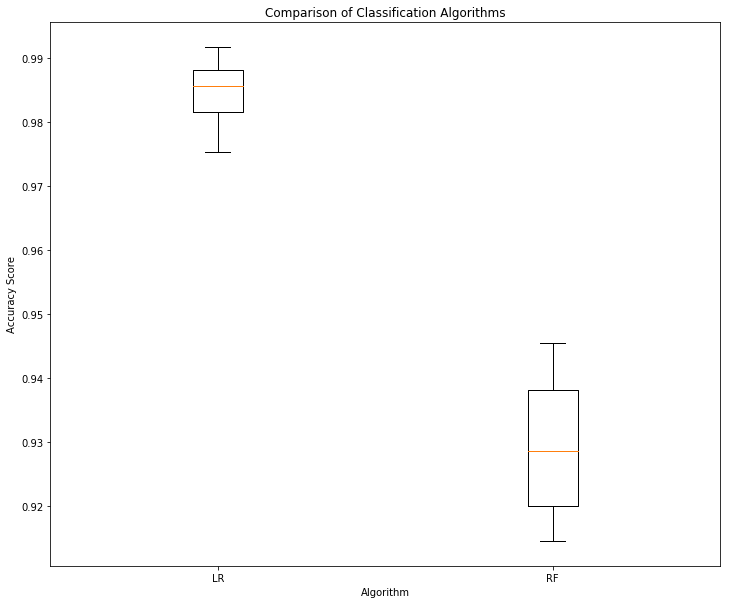

In [96]:

#Compare Algorithms

fig = plt.figure(figsize=(12,10))
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy Score')
plt.boxplot(results)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
plt.show()

# make predictions

In [97]:
lrc = LogisticRegression()

In [98]:
lrc.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [99]:
pred = lrc.predict(X_test)

In [103]:
accuracy_score(y_test, pred, normalize=True)

0.99025609631670242

In [ ]:
classification_report(y_test, y_pred)

In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat

In [ ]:
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,
               s=confmat[i,j],
               va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [ ]:
# insted rf put best model
importances = rf.steps[2][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.steps[2][1].estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
feature_names = np.array(list(train.columns.values))
feature_names

In [ ]:
# one-hot-encod makes many sparsity columns, and models cound not take them into account
# from first article check TargetEncoder
# https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a
# https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159
# for large number of cat_values try binarEncoding

In [ ]:
# from second how to make pipeline and use H2ORandomForest
# drop features which have importance less that 100th feature
# third post has Class Prediction Error (CPE) and link to post with NN
# concat train and test when we work with data, but in the end separeti them

In [107]:
lrc.fit(df_preproc_t, target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [108]:
ls

1.0-DP-beer_dataset.ipynb             SubmissionFormat.csv
1.1-DP_waterpomps.ipynb               beer_reviews.csv
1.3-DP_waterpomps_simplier.ipynb      prepeared_features.csv
1.4-DP_work_with_cats_features.ipynb  target.csv
2.0-DP_raw_data_visualization.ipynb   test.csv
2.1-DP_prepare_data.ipynb             train.csv


In [197]:
def prepare_numeric_features(df):
    df['missed_population'] = np.where(np.isnan(df['population']), 1, 0)
    df['population'].fillna(0, inplace = True)
    df['approximated_amount_tsh'] = np.where(np.isnan(df['amount_tsh']), 1, 0) 
    replacements = df.groupby('water_quality').amount_tsh.agg(pd.Series.mode).to_dict()
    replacements.pop('fluoride abandoned')
    df.loc[df['water_quality'] != 'soft', 'amount_tsh'] = \
        df.loc[df['water_quality'] != 'soft', 'amount_tsh'].fillna(replacements)
    df['amount_tsh'].fillna(0, inplace=True)
    df['wrong_gps_height'] = np.where(df['gps_height'] < 0, 1, 0) 
    df['gps_height'] = abs(df['gps_height'])
    return df


def prepare_categorical_features(df, categoricals):
    df[categoricals] = df[categoricals].astype('str')
    df[categoricals] = df[categoricals].applymap(lambda x: x.lower())
    nan_list = ['not known','unknown','none','-','##','not kno','unknown installer', '0', 'dwe']
    df = df.replace(nan_list, np.nan)

    # Any feature values with fewer than 50 rows would be turned into a 'other'
    for feature in df[categoricals]:
        # Determine which feature values to keep
        remove = df[feature].value_counts()[df[feature].value_counts() < 50].index.tolist()
        #print(remove)
        #to_keep = train[feature].value_counts()[train[feature].value_counts() > 50].index.tolist()

        # Turn those into NANs (using a copy, to prevent warnings)
        feature_copy = df[feature].copy()
        #feature_copy[~feature_copy.isin(to_keep)] = np.nan
        feature_copy[feature_copy.isin(remove)] = np.nan
        #print(feature_copy.isnull().sum())
        df[feature] = feature_copy
    # Fix all NANs
    df[categoricals] = df[categoricals].fillna('other') 
    df.management_group = df.management_group.apply(lambda x: 'other' if x != 'user-group' else x)
    unpayable_types = ['never pay', 'other']
    df.payment = df.payment.apply(lambda x: 0 if x in unpayable_types else 1)
    df.quantity.replace({'dry': 'other'}, inplace=True)
    df.waterpoint_type.replace({'cattle trough':'improved spring'}, inplace=True)
    df.drop(['region', 'district_code', 'extraction_type_group', 'extraction_type_class', 'management', 
             'management_group', 'payment_type', 'water_quality', 'quantity_group', 'source_class', 'source_type',
             'waterpoint_type_group'], 1, inplace=True)
    

    return df


def prepare_data_features(test_df, train_df):
    train_df_temp = train_df.copy()
    test_df[['date_recorded', 'construction_year']]= test_df[['date_recorded', 'construction_year']].apply((pd.to_datetime))
    train_df_temp['id'] = 0
    df = test_df.append(train_df_temp)
    df.construction_year.fillna(0, inplace=True)
    df.construction_year = df.construction_year.astype(int)
    df.construction_year = df.construction_year.replace(0, np.NaN)
    df['approximated_construction_year'] = df['construction_year'].apply(lambda x: 1 if np.isnan(x) else 0)
    replacements = df.groupby(['funder', 'installer'])['construction_year'].transform('mean').round(0)
    df['construction_year'] = df['construction_year'].fillna(replacements)

    replacements = df.groupby('installer')['construction_year'].transform('mean').round(0)
    df['construction_year'] = df['construction_year'].fillna(replacements)

    replacements = df.groupby('funder')['construction_year'].transform('mean').round(0)
    df['construction_year'] = df['construction_year'].fillna(replacements)

    df.construction_year.fillna(df.construction_year.mode()[0], inplace=True)

    return df[df.id != 0]

In [193]:
test_prep = prepare_numeric_features(test)

In [194]:
test_prep = prepare_categorical_features(test_prep, categoricals)

In [198]:
test_prep = prepare_data_features(test_prep, df)

In [ ]:
train_dum.columns

In [207]:
train_dum_t = pd.get_dummies(test_prep, dummy_na=False, prefix = categorial)
train_dum_t.shape

ValueError: Length of 'prefix' (12) did not match the length of the columns being encoded (32).

In [206]:
train_dum.shape

(59400, 4153)

In [200]:
test_prep.id

0        50785
1        51630
2        17168
3        45559
4        49871
5        52449
6        24806
7        28965
8        36301
9        54122
10         419
11       45750
12         653
13       14017
14       44607
15       40228
16       27714
17       28785
18       28330
19       18532
20       69961
21       55083
22        8691
23       30331
24       70970
25       61136
26       28799
27       46825
28       44718
29       37350
         ...  
14820    52228
14821    70038
14822    25901
14823    21131
14824    26580
14825    66059
14826    32944
14827    13686
14828     8471
14829    19620
14830    74162
14831    37994
14832    71151
14833    45017
14834    12592
14835    58693
14836    57539
14837    71252
14838     7869
14839    57316
14840    59757
14841    64579
14842    57731
14843    65541
14844    68174
14845    39307
14846    18990
14847    28749
14848    33492
14849    68707
Name: id, Length: 14850, dtype: int64

use get_dummies for test and train togather

In [201]:
pred = lrc.predict(test_prep)

ValueError: could not convert string to float: 'Kwa Mzee Chagala'

In [109]:
### or date recorder could be limitation of construction year
# Any feature values with fewer than 50 rows gets turned into a NAN, but this value better to test on cross-validation
# later


In [2]:
!pip install catboost==0.14.0

     |████████████████████████████████| 8.0MB 4.6MB/s eta 0:00:01     |▏                               | 40kB 427kB/s eta 0:00:19
  Found existing installation: catboost 0.15.2
    Uninstalling catboost-0.15.2:
      Successfully uninstalled catboost-0.15.2


In [3]:
import catboost